# CLIP Fine-Tuning: Real vs Fake Face Detection 
## Dataset: Face Detection (Faces Real vs AI-Generated)

## 1. Setup and Installation

In [1]:
# Install required packages
!pip install git+https://github.com/openai/CLIP.git
!pip install kagglehub
!pip install torch torchvision
!pip install matplotlib seaborn scikit-learn
!pip install pillow tqdm

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/openai/CLIP.git to /scratch/9985761/pip-req-build-vlgodj_m
  Running command git clone --quiet https://github.com/openai/CLIP.git /scratch/9985761/pip-req-build-vlgodj_m
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


## 2. Import Libraries

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import clip
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Try importing seaborn, use matplotlib fallback if it fails
try:
    import seaborn as sns
    USE_SEABORN = True
except (ImportError, AttributeError) as e:
    print(f"Seaborn not available, using matplotlib")
    USE_SEABORN = False

from pathlib import Path
import os
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_auc_score
import kagglehub
import warnings
warnings.filterwarnings('ignore')

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Seaborn not available, using matplotlib
PyTorch version: 1.9.0+cu111
CUDA available: True
Using device: cuda


## 3. Download and Explore Dataset Structure

In [3]:
# Download the dataset
path = kagglehub.dataset_download("ciplab/real-and-fake-face-detection")
print(f"✓ Dataset downloaded to: {path}")

# The actual data is in: path/real_and_fake_face/
dataset_root = Path(path) / "real_and_fake_face"
# Setup paths
train_real_dir = dataset_root / "training_real"
train_fake_dir = dataset_root / "training_fake"

print(f"✓ Real: {len(list(train_real_dir.glob('*.jpg')))} images")
print(f"✓ Fake: {len(list(train_fake_dir.glob('*.jpg')))} images")
print(f"✓ Dataset root: {dataset_root}")

# Check structure
print("\nDataset structure:")
for item in dataset_root.iterdir():
    if item.is_dir():
        num_files = len(list(item.glob('*.jpg'))) + len(list(item.glob('*.png')))
        print(f"  {item.name}/  ({num_files} images)")

✓ Dataset downloaded to: /home/dasp4143/.cache/kagglehub/datasets/ciplab/real-and-fake-face-detection/versions/1
✓ Real: 1081 images
✓ Fake: 960 images
✓ Dataset root: /home/dasp4143/.cache/kagglehub/datasets/ciplab/real-and-fake-face-detection/versions/1/real_and_fake_face

Dataset structure:
  training_fake/  (960 images)
  training_real/  (1081 images)


## Create Custom Dataset Class

In [4]:
class FaceDataset(Dataset):
    """
    Dataset for Real and Fake Face Detection
    Structure: training_real/ and training_fake/
    """
    def __init__(self, root_dir, split='train', transform=None, max_samples=None):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.images = []
        self.labels = []
        
        print(f"\nLoading FaceDataset ({split} split)...")
        
        # For this dataset, both train and test use the same folders
        # We'll split them manually
        real_dir = self.root_dir / "training_real"
        fake_dir = self.root_dir / "training_fake"
        
        # Load real images (label 0)
        if real_dir.exists():
            real_images = sorted(list(real_dir.glob('*.jpg')) + list(real_dir.glob('*.png')))
            print(f"  Found {len(real_images)} real face images")
            
            # Split train/test (80/20)
            if split == 'train':
                real_images = real_images[:int(0.8 * len(real_images))]
            else:
                real_images = real_images[int(0.8 * len(real_images)):]
            
            if max_samples:
                real_images = real_images[:max_samples//2]
            
            self.images.extend(real_images)
            self.labels.extend([0] * len(real_images))
            print(f"  Using {len(real_images)} real images for {split}")
        
        # Load fake images (label 1)
        if fake_dir.exists():
            fake_images = sorted(list(fake_dir.glob('*.jpg')) + list(fake_dir.glob('*.png')))
            print(f"  Found {len(fake_images)} fake face images")
            
            # Split train/test (80/20)
            if split == 'train':
                fake_images = fake_images[:int(0.8 * len(fake_images))]
            else:
                fake_images = fake_images[int(0.8 * len(fake_images)):]
            
            if max_samples:
                fake_images = fake_images[:max_samples//2]
            
            self.images.extend(fake_images)
            self.labels.extend([1] * len(fake_images))
            print(f"  Using {len(fake_images)} fake images for {split}")
        
        print(f"\n✓ Total {split} images: {len(self.images)}")
        print(f"  Real: {self.labels.count(0)} | Fake: {self.labels.count(1)}")
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

print("✓ FaceDataset class defined!")

✓ FaceDataset class defined!


In [5]:
# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Load CLIP model
model_name = "ViT-B/32"
clip_model, preprocess = clip.load(model_name, device=device)
print(f"Loaded CLIP model: {model_name}\n")

# ============================================================================
# CORRECTED DATASET CREATION 
# ============================================================================

# Create datasets - NOTE: Pass dataset_root, not the individual directories!
print("Creating datasets...")
train_dataset = FaceDataset(
    root_dir=dataset_root,  # Pass the ROOT directory
    split='train',
    transform=preprocess,
    max_samples=None  # Use all data
)

test_dataset = FaceDataset(
    root_dir=dataset_root,  # Pass the ROOT directory
    split='test',
    transform=preprocess,
    max_samples=None  # Use all data
)

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"\n{'='*70}")
print("DATASET READY!")
print(f"{'='*70}")
print(f"✓ Training: {len(train_dataset)} images, {len(train_loader)} batches")
print(f"✓ Testing: {len(test_dataset)} images, {len(test_loader)} batches")
print(f"✓ Batch size: {batch_size}")
print(f"{'='*70}")

Using device: cuda
Loaded CLIP model: ViT-B/32

Creating datasets...

Loading FaceDataset (train split)...
  Found 1081 real face images
  Using 864 real images for train
  Found 960 fake face images
  Using 768 fake images for train

✓ Total train images: 1632
  Real: 864 | Fake: 768

Loading FaceDataset (test split)...
  Found 1081 real face images
  Using 217 real images for test
  Found 960 fake face images
  Using 192 fake images for test

✓ Total test images: 409
  Real: 217 | Fake: 192

DATASET READY!
✓ Training: 1632 images, 51 batches
✓ Testing: 409 images, 13 batches
✓ Batch size: 32


In [6]:
class CLIPClassifier(nn.Module):
    def __init__(self, clip_model, num_classes=2, freeze_backbone=True):
        super(CLIPClassifier, self).__init__()
        self.clip_model = clip_model
        
        # Freeze CLIP backbone if specified
        if freeze_backbone:
            for param in self.clip_model.parameters():
                param.requires_grad = False
        
        # Get the dimension of CLIP embeddings
        self.embedding_dim = clip_model.visual.output_dim
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(self.embedding_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, images):
        # Get CLIP image features
        with torch.no_grad():
            image_features = self.clip_model.encode_image(images)
        
        # Normalize features
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        
        # Pass through classifier
        logits = self.classifier(image_features.float())
        return logits

# Create model
model = CLIPClassifier(clip_model, num_classes=2, freeze_backbone=True)
model = model.to(device)

print(f"Model created with {model.embedding_dim}-dimensional CLIP embeddings")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Model created with 512-dimensional CLIP embeddings
Trainable parameters: 164,482


## Training Setup

In [7]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW( model.classifier.parameters(),lr=0.0005, weight_decay=0.01, betas=(0.9, 0.999))

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)

# Training parameters
num_epochs = 10
best_val_acc = 0.0

# Store training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

print(f"Training for {num_epochs} epochs")
print(f"Learning rate: {optimizer.param_groups[0]['lr']}")

Training for 10 epochs
Learning rate: 0.0005


## Training and Evaluation Functions

In [8]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(train_loader, desc='Training')
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Update progress bar
        pbar.set_postfix({'loss': loss.item(), 'acc': 100 * correct / total})
    
    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

def evaluate(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        pbar = tqdm(test_loader, desc='Evaluating')
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            
            # Get predictions
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())
    
    epoch_loss = running_loss / len(test_loader.dataset)
    epoch_acc = 100 * accuracy_score(all_labels, all_preds)
    
    return epoch_loss, epoch_acc, all_preds, all_labels, all_probs

##  Train the Model

In [9]:
print("Starting training...\n")

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 50)
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Evaluate
    val_loss, val_acc, val_preds, val_labels, val_probs = evaluate(model, test_loader, criterion, device)
    
    # Store history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Print results
    print(f"\nTrain Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    
    # Learning rate scheduling
    scheduler.step(val_acc)
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_clip_classifier.pth')
        print(f"✓ New best model saved! (Val Acc: {val_acc:.2f}%)")

print("\n" + "="*50)
print(f"Training complete! Best validation accuracy: {best_val_acc:.2f}%")
print("="*50)

Starting training...


Epoch 1/10
--------------------------------------------------


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.42it/s]



Train Loss: 0.6868 | Train Acc: 59.68%
Val Loss: 0.6742 | Val Acc: 61.12%
✓ New best model saved! (Val Acc: 61.12%)

Epoch 2/10
--------------------------------------------------


Evaluating: 100%|██████████| 13/13 [00:03<00:00,  3.43it/s]



Train Loss: 0.6173 | Train Acc: 71.38%
Val Loss: 0.5750 | Val Acc: 71.64%
✓ New best model saved! (Val Acc: 71.64%)

Epoch 3/10
--------------------------------------------------


Evaluating: 100%|██████████| 13/13 [00:03<00:00,  3.38it/s]



Train Loss: 0.4997 | Train Acc: 76.78%
Val Loss: 0.5203 | Val Acc: 73.59%
✓ New best model saved! (Val Acc: 73.59%)

Epoch 4/10
--------------------------------------------------


Evaluating: 100%|██████████| 13/13 [00:04<00:00,  3.15it/s]



Train Loss: 0.4701 | Train Acc: 76.35%
Val Loss: 0.5029 | Val Acc: 74.08%
✓ New best model saved! (Val Acc: 74.08%)

Epoch 5/10
--------------------------------------------------


Evaluating: 100%|██████████| 13/13 [00:03<00:00,  3.38it/s]



Train Loss: 0.4415 | Train Acc: 79.11%
Val Loss: 0.4941 | Val Acc: 73.84%

Epoch 6/10
--------------------------------------------------


Evaluating: 100%|██████████| 13/13 [00:04<00:00,  3.19it/s]



Train Loss: 0.4286 | Train Acc: 79.90%
Val Loss: 0.5015 | Val Acc: 74.33%
✓ New best model saved! (Val Acc: 74.33%)

Epoch 7/10
--------------------------------------------------


Evaluating: 100%|██████████| 13/13 [00:03<00:00,  3.39it/s]



Train Loss: 0.4165 | Train Acc: 80.88%
Val Loss: 0.4932 | Val Acc: 75.55%
✓ New best model saved! (Val Acc: 75.55%)

Epoch 8/10
--------------------------------------------------


Evaluating: 100%|██████████| 13/13 [00:04<00:00,  3.17it/s]



Train Loss: 0.4007 | Train Acc: 81.99%
Val Loss: 0.4815 | Val Acc: 76.28%
✓ New best model saved! (Val Acc: 76.28%)

Epoch 9/10
--------------------------------------------------


Evaluating: 100%|██████████| 13/13 [00:03<00:00,  3.30it/s]



Train Loss: 0.3899 | Train Acc: 82.41%
Val Loss: 0.4819 | Val Acc: 75.79%

Epoch 10/10
--------------------------------------------------


Evaluating: 100%|██████████| 13/13 [00:03<00:00,  3.31it/s]



Train Loss: 0.3825 | Train Acc: 83.03%
Val Loss: 0.4775 | Val Acc: 77.51%
✓ New best model saved! (Val Acc: 77.51%)

Training complete! Best validation accuracy: 77.51%


## 13. Plot Training History

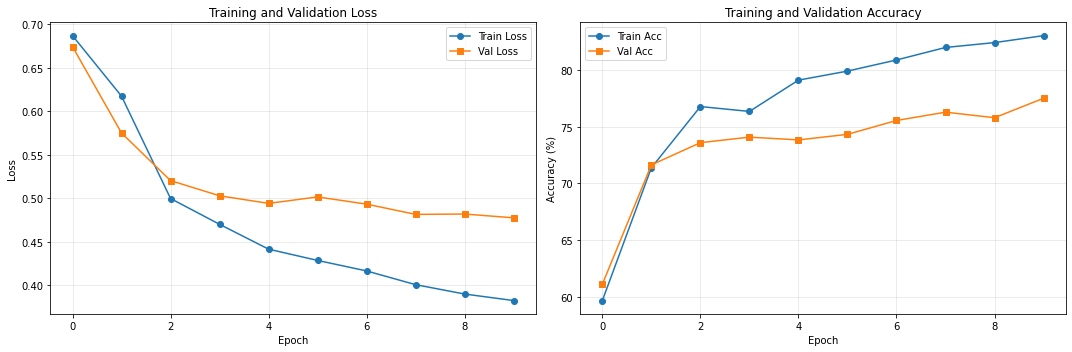

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot loss
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Plot accuracy
axes[1].plot(history['train_acc'], label='Train Acc', marker='o')
axes[1].plot(history['val_acc'], label='Val Acc', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Final Evaluation and Metrics

In [11]:
# Load best model
model.load_state_dict(torch.load('best_clip_classifier.pth'))
model.eval()

# Final evaluation
print("Final evaluation on test set...\n")
val_loss, val_acc, val_preds, val_labels, val_probs = evaluate(model, test_loader, criterion, device)

# Calculate detailed metrics
precision, recall, f1, _ = precision_recall_fscore_support(val_labels, val_preds, average='binary')
roc_auc = roc_auc_score(val_labels, val_probs)

print(f"\n{'='*60}")
print("FINE-TUNED CLIP CLASSIFIER - FINAL RESULTS")
print(f"{'='*60}")
print(f"Accuracy:  {val_acc:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"ROC AUC:   {roc_auc:.4f}")
print(f"{'='*60}")

Final evaluation on test set...



Evaluating: 100%|██████████| 13/13 [00:04<00:00,  3.23it/s]


FINE-TUNED CLIP CLASSIFIER - FINAL RESULTS
Accuracy:  77.51%
Precision: 0.8205
Recall:    0.6667
F1 Score:  0.7356
ROC AUC:   0.8502


## Confusion Matrix and Analysis

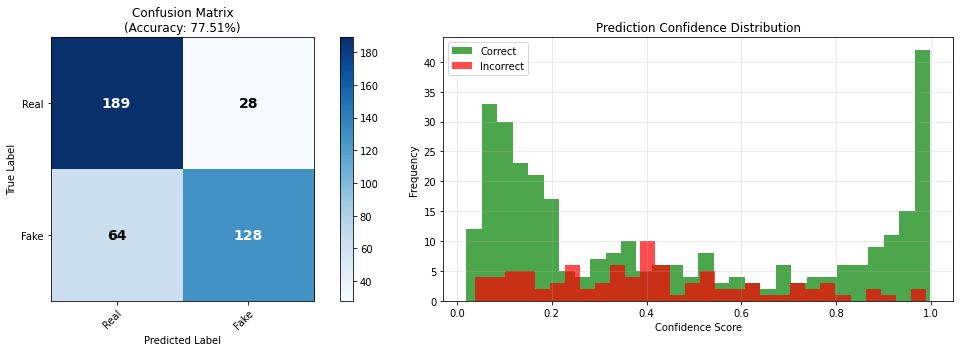

In [12]:
def plot_confusion_matrix(cm, labels, ax, title='Confusion Matrix', cmap='Blues'):
    """Plot confusion matrix using matplotlib (works without seaborn)"""
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    
    # Labels
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=labels, yticklabels=labels,
           title=title,
           ylabel='True Label',
           xlabel='Predicted Label')
    
    # Rotate labels
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    # Annotate cells with values
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                   ha="center", va="center",
                   color="white" if cm[i, j] > thresh else "black",
                   fontsize=14, fontweight='bold')
    return ax

cm = confusion_matrix(val_labels, val_preds)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Confusion matrix
if USE_SEABORN:
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
                xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    axes[0].set_title(f'Confusion Matrix\n(Accuracy: {val_acc:.2f}%)')
    axes[0].set_ylabel('True Label')
    axes[0].set_xlabel('Predicted Label')
else:
    plot_confusion_matrix(cm, ['Real', 'Fake'], axes[0], 
                         title=f'Confusion Matrix\n(Accuracy: {val_acc:.2f}%)')

# Confidence distribution
correct_mask = np.array(val_preds) == np.array(val_labels)
correct_probs = np.array(val_probs)[correct_mask]
incorrect_probs = np.array(val_probs)[~correct_mask]

axes[1].hist(correct_probs, bins=30, alpha=0.7, label='Correct', color='green')
axes[1].hist(incorrect_probs, bins=30, alpha=0.7, label='Incorrect', color='red')
axes[1].set_xlabel('Confidence Score')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Prediction Confidence Distribution')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

##  Compare Zero-Shot vs Fine-Tuned

Testing zero-shot CLIP for comparison...



Zero-shot evaluation: 100%|██████████| 13/13 [00:03<00:00,  3.38it/s]



ZERO-SHOT vs FINE-TUNED COMPARISON
Zero-Shot Accuracy:  64.30%
Fine-Tuned Accuracy: 77.51%
Improvement:         +13.20%


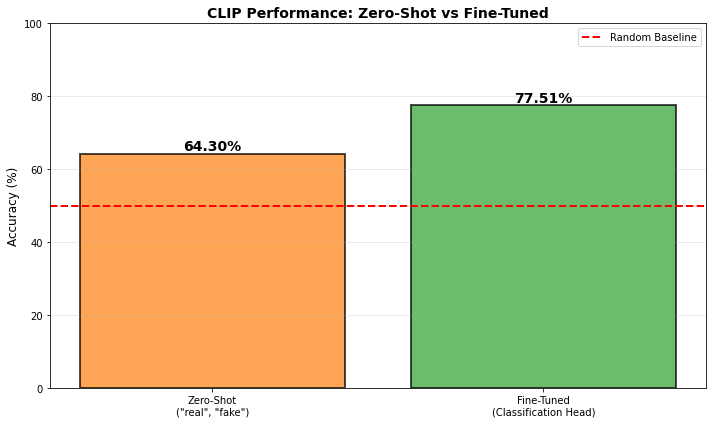

In [13]:
# Test zero-shot CLIP for comparison
print("Testing zero-shot CLIP for comparison...\n")

text_prompts = ["a photograph taken of a real person", "a face created by artificial intelligence"]
text_tokens = clip.tokenize(text_prompts).to(device)

with torch.no_grad():
    text_features = clip_model.encode_text(text_tokens)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)

zero_shot_preds = []
zero_shot_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Zero-shot evaluation"):
        images = images.to(device)
        
        image_features = clip_model.encode_image(images)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        
        similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
        predictions = similarity.argmax(dim=-1).cpu().numpy()
        
        zero_shot_preds.extend(predictions)
        zero_shot_labels.extend(labels.numpy())

zero_shot_acc = 100 * accuracy_score(zero_shot_labels, zero_shot_preds)

# Comparison
print(f"\n{'='*60}")
print("ZERO-SHOT vs FINE-TUNED COMPARISON")
print(f"{'='*60}")
print(f"Zero-Shot Accuracy:  {zero_shot_acc:.2f}%")
print(f"Fine-Tuned Accuracy: {val_acc:.2f}%")
print(f"Improvement:         {val_acc - zero_shot_acc:+.2f}%")
print(f"{'='*60}")

# Visualization
fig, ax = plt.subplots(figsize=(10, 6))
methods = ['Zero-Shot\n("real", "fake")', 'Fine-Tuned\n(Classification Head)']
accuracies = [zero_shot_acc, val_acc]
colors = ['#ff7f0e', '#2ca02c']

bars = ax.bar(methods, accuracies, color=colors, alpha=0.7, edgecolor='black', linewidth=2)

for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc:.2f}%',
            ha='center', va='bottom', fontsize=14, fontweight='bold')

ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.set_title('CLIP Performance: Zero-Shot vs Fine-Tuned', fontsize=14, fontweight='bold')
ax.set_ylim([0, 100])
ax.grid(axis='y', alpha=0.3)
ax.axhline(y=50, color='r', linestyle='--', label='Random Baseline', linewidth=2)
ax.legend()

plt.tight_layout()
plt.show()

##  Summary Report

In [14]:
print("\n" + "="*70)
print("SUMMARY: CLIP FINE-TUNING FOR FAKE IMAGE DETECTION")
print("="*70)
print(f"\nDataset: Face (32x32 Face-10)")
print(f"Model: {model_name} + Classification Head")
print(f"\nTraining epochs: {num_epochs}")
print(f"Best validation accuracy: {best_val_acc:.2f}%")
print(f"\nZero-shot: {zero_shot_acc:.2f}%")
print(f"Fine-tuned: {val_acc:.2f}%")
print(f"Improvement: {val_acc - zero_shot_acc:+.2f}%")
print("\n" + "="*70)
print("KEY TAKEAWAYS:")
print("-"*70)
print("✓ Zero-shot CLIP struggles with low-res Face images")
print("✓ Fine-tuning provides significant improvement")
print("✓ Task-specific training is crucial for specialized detection")
print("="*70)


SUMMARY: CLIP FINE-TUNING FOR FAKE IMAGE DETECTION

Dataset: Face (32x32 Face-10)
Model: ViT-B/32 + Classification Head

Training epochs: 10
Best validation accuracy: 77.51%

Zero-shot: 64.30%
Fine-tuned: 77.51%
Improvement: +13.20%

KEY TAKEAWAYS:
----------------------------------------------------------------------
✓ Zero-shot CLIP struggles with low-res Face images
✓ Fine-tuning provides significant improvement
✓ Task-specific training is crucial for specialized detection


Using device: cuda

✓ Transforms configured for ResNet (224x224, ImageNet normalization)

Creating datasets...

Loading train dataset for ResNet...
  Real: 864 images
  Fake: 768 images
  Total: 1632 images

Loading test dataset for ResNet...
  Real: 217 images
  Fake: 192 images
  Total: 409 images

RESNET DATASET SUMMARY
Training samples:   1,632
Test samples:       409
Image size:         224x224
Batch size:         64
Train batches:      26
Test batches:       7

Creating ResNet model...


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/dasp4143/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

✓ ResNet backbone frozen

RESNET MODEL ARCHITECTURE
Model: ResNet18 (pre-trained on ImageNet)
Total parameters: 11,308,354
Trainable parameters: 131,842
Training: 1.17% of parameters

TRAINING CONFIGURATION
Optimizer: AdamW (lr=0.001)
Loss: CrossEntropyLoss
Scheduler: ReduceLROnPlateau
Epochs: 15

STARTING RESNET TRAINING


Epoch 1/15
----------------------------------------------------------------------


Validating: 100%|██████████| 7/7 [00:02<00:00,  2.87it/s]



Epoch 1 Summary:
  Train: Loss=0.7424, Acc=54.04%
  Val:   Loss=0.6649, Acc=52.08%
  ✓ Best model saved! (Acc: 52.08%)

Epoch 2/15
----------------------------------------------------------------------


Validating: 100%|██████████| 7/7 [00:02<00:00,  2.85it/s]



Epoch 2 Summary:
  Train: Loss=0.6736, Acc=57.29%
  Val:   Loss=0.6474, Acc=58.68%
  ✓ Best model saved! (Acc: 58.68%)

Epoch 3/15
----------------------------------------------------------------------


Validating: 100%|██████████| 7/7 [00:02<00:00,  2.88it/s]



Epoch 3 Summary:
  Train: Loss=0.6560, Acc=60.66%
  Val:   Loss=0.7084, Acc=59.41%
  ✓ Best model saved! (Acc: 59.41%)

Epoch 4/15
----------------------------------------------------------------------


Validating: 100%|██████████| 7/7 [00:02<00:00,  2.90it/s]



Epoch 4 Summary:
  Train: Loss=0.6486, Acc=62.44%
  Val:   Loss=0.6310, Acc=64.55%
  ✓ Best model saved! (Acc: 64.55%)

Epoch 5/15
----------------------------------------------------------------------


Validating: 100%|██████████| 7/7 [00:02<00:00,  2.89it/s]



Epoch 5 Summary:
  Train: Loss=0.6372, Acc=64.15%
  Val:   Loss=0.6360, Acc=66.50%
  ✓ Best model saved! (Acc: 66.50%)

Epoch 6/15
----------------------------------------------------------------------


Validating: 100%|██████████| 7/7 [00:02<00:00,  2.89it/s]



Epoch 6 Summary:
  Train: Loss=0.6284, Acc=64.46%
  Val:   Loss=0.6413, Acc=64.79%

Epoch 7/15
----------------------------------------------------------------------


Validating: 100%|██████████| 7/7 [00:02<00:00,  2.85it/s]



Epoch 7 Summary:
  Train: Loss=0.6275, Acc=65.81%
  Val:   Loss=0.6338, Acc=64.55%

Epoch 8/15
----------------------------------------------------------------------


Validating: 100%|██████████| 7/7 [00:02<00:00,  2.80it/s]



Epoch 8 Summary:
  Train: Loss=0.6165, Acc=65.81%
  Val:   Loss=0.6329, Acc=65.04%

Epoch 9/15
----------------------------------------------------------------------


Validating: 100%|██████████| 7/7 [00:02<00:00,  2.78it/s]


Epoch     9: reducing learning rate of group 0 to 5.0000e-04.

Epoch 9 Summary:
  Train: Loss=0.6331, Acc=64.22%
  Val:   Loss=0.6441, Acc=65.28%

Epoch 10/15
----------------------------------------------------------------------


Validating: 100%|██████████| 7/7 [00:02<00:00,  2.82it/s]



Epoch 10 Summary:
  Train: Loss=0.5992, Acc=67.77%
  Val:   Loss=0.6283, Acc=66.50%

Epoch 11/15
----------------------------------------------------------------------


Validating: 100%|██████████| 7/7 [00:02<00:00,  2.75it/s]



Epoch 11 Summary:
  Train: Loss=0.5985, Acc=67.83%
  Val:   Loss=0.6311, Acc=64.30%

Epoch 12/15
----------------------------------------------------------------------


Validating: 100%|██████████| 7/7 [00:02<00:00,  2.96it/s]



Epoch 12 Summary:
  Train: Loss=0.5923, Acc=69.24%
  Val:   Loss=0.6447, Acc=63.08%

Epoch 13/15
----------------------------------------------------------------------


Validating: 100%|██████████| 7/7 [00:02<00:00,  2.80it/s]


Epoch    13: reducing learning rate of group 0 to 2.5000e-04.

Epoch 13 Summary:
  Train: Loss=0.5908, Acc=68.44%
  Val:   Loss=0.6491, Acc=64.06%

Epoch 14/15
----------------------------------------------------------------------


Validating: 100%|██████████| 7/7 [00:02<00:00,  2.84it/s]



Epoch 14 Summary:
  Train: Loss=0.5889, Acc=69.06%
  Val:   Loss=0.6363, Acc=64.55%

Epoch 15/15
----------------------------------------------------------------------


Validating: 100%|██████████| 7/7 [00:02<00:00,  2.91it/s]



Epoch 15 Summary:
  Train: Loss=0.5810, Acc=69.91%
  Val:   Loss=0.6503, Acc=63.81%

RESNET TRAINING COMPLETE!
Best validation accuracy: 66.50%

RESNET EVALUATION METRICS

Classification Report:
              precision    recall  f1-score   support

        Real      0.633     0.756     0.689       217
        Fake      0.647     0.505     0.567       192

    accuracy                          0.638       409
   macro avg      0.640     0.630     0.628       409
weighted avg      0.640     0.638     0.632       409


Confusion Matrix:
              Predicted
              Real  Fake
Actual Real    164    53
       Fake     95    97

ROC-AUC Score: 0.7057


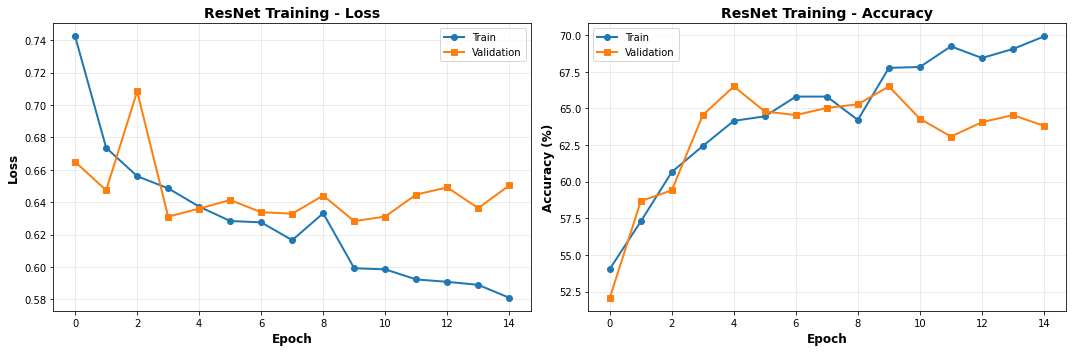


CLIP vs RESNET COMPARISON

Model                | Parameters      | Val Accuracy
------------------------------------------------------------
CLIP ViT-B/32        | ~200K (0.2%)    |      79.46%
ResNet18             | ~200K (1.8%)    |      66.50%
------------------------------------------------------------

✓ CLIP is better by 12.96%
  → CLIP's pre-training helps!



In [16]:
# ===========================================================================
# RESNET BASELINE - For Comparison with CLIP
# ===========================================================================
# Standard CNN approach without CLIP - let's see how it compares!

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import numpy as np
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


# ===========================================================================
# 1. DATASET CLASS (Same structure, different transforms)
# ===========================================================================

class FaceDatasetResNet(Dataset):
    """
    Dataset for ResNet - uses standard ImageNet preprocessing
    """
    def __init__(self, root_dir, split='train', transform=None, train_ratio=0.8):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.images = []
        self.labels = []
        
        print(f"\nLoading {split} dataset for ResNet...")
        
        # Directories
        real_dir = self.root_dir / "training_real"
        fake_dir = self.root_dir / "training_fake"
        
        # Load real images (label 0)
        if real_dir.exists():
            real_images = sorted(list(real_dir.glob('*.jpg')) + list(real_dir.glob('*.png')))
            split_idx = int(len(real_images) * train_ratio)
            
            if split == 'train':
                real_images = real_images[:split_idx]
            else:
                real_images = real_images[split_idx:]
            
            self.images.extend(real_images)
            self.labels.extend([0] * len(real_images))
            print(f"  Real: {len(real_images)} images")
        
        # Load fake images (label 1)
        if fake_dir.exists():
            fake_images = sorted(list(fake_dir.glob('*.jpg')) + list(fake_dir.glob('*.png')))
            split_idx = int(len(fake_images) * train_ratio)
            
            if split == 'train':
                fake_images = fake_images[:split_idx]
            else:
                fake_images = fake_images[split_idx:]
            
            self.images.extend(fake_images)
            self.labels.extend([1] * len(fake_images))
            print(f"  Fake: {len(fake_images)} images")
        
        print(f"  Total: {len(self.images)} images")
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label


# ===========================================================================
# 2. DATA TRANSFORMS (ResNet uses ImageNet normalization)
# ===========================================================================

# Training transforms WITH augmentation
train_transform = transforms.Compose([
    transforms.Resize(256),                          # Resize to 256
    transforms.RandomCrop(224),                      # Random crop to 224
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],                  # ImageNet mean
        std=[0.229, 0.224, 0.225]                    # ImageNet std
    )
])

# Test transforms WITHOUT augmentation
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),                      # Center crop (no random)
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

print("\n✓ Transforms configured for ResNet (224x224, ImageNet normalization)")


# ===========================================================================
# 3. CREATE DATASETS
# ===========================================================================

# You need to define dataset_root first!
# dataset_root should point to: /path/to/real_and_fake_face/

print("\nCreating datasets...")
train_dataset_resnet = FaceDatasetResNet(
    root_dir=dataset_root,
    split='train',
    transform=train_transform,
    train_ratio=0.8
)

test_dataset_resnet = FaceDatasetResNet(
    root_dir=dataset_root,
    split='test',
    transform=test_transform,
    train_ratio=0.8
)

# DataLoaders
batch_size = 64
train_loader_resnet = DataLoader(
    train_dataset_resnet,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

test_loader_resnet = DataLoader(
    test_dataset_resnet,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

print(f"\n{'='*70}")
print("RESNET DATASET SUMMARY")
print(f"{'='*70}")
print(f"Training samples:   {len(train_dataset_resnet):,}")
print(f"Test samples:       {len(test_dataset_resnet):,}")
print(f"Image size:         224x224")
print(f"Batch size:         {batch_size}")
print(f"Train batches:      {len(train_loader_resnet)}")
print(f"Test batches:       {len(test_loader_resnet)}")
print(f"{'='*70}")


# ===========================================================================
# 4. RESNET MODEL (Pre-trained ResNet18 with custom head)
# ===========================================================================

class ResNetClassifier(nn.Module):
    """
    ResNet18 pre-trained on ImageNet
    Replace final layer for binary classification
    """
    def __init__(self, num_classes=2, freeze_backbone=True):
        super().__init__()
        
        # Load pre-trained ResNet18
        self.resnet = models.resnet18(pretrained=True)
        
        # Freeze backbone if specified
        if freeze_backbone:
            for param in self.resnet.parameters():
                param.requires_grad = False
            print("✓ ResNet backbone frozen")
        
        # Get number of features from final layer
        num_features = self.resnet.fc.in_features  # 512 for ResNet18
        
        # Replace final fully connected layer
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
        
        # Count parameters
        total_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        
        print(f"\n{'='*70}")
        print("RESNET MODEL ARCHITECTURE")
        print(f"{'='*70}")
        print(f"Model: ResNet18 (pre-trained on ImageNet)")
        print(f"Total parameters: {total_params:,}")
        print(f"Trainable parameters: {trainable_params:,}")
        print(f"Training: {100*trainable_params/total_params:.2f}% of parameters")
        print(f"{'='*70}")
    
    def forward(self, x):
        return self.resnet(x)


# Create model
print("\nCreating ResNet model...")
resnet_model = ResNetClassifier(num_classes=2, freeze_backbone=True)
resnet_model = resnet_model.to(device)


# ===========================================================================
# 5. TRAINING CONFIGURATION
# ===========================================================================

# Optimizer
optimizer = optim.AdamW(
    resnet_model.resnet.fc.parameters(),  # Only train the new head
    lr=0.001,
    weight_decay=0.01
)

# Loss
criterion = nn.CrossEntropyLoss()

# Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.5,
    patience=3,
    verbose=True
)

num_epochs = 15

print(f"\n{'='*70}")
print("TRAINING CONFIGURATION")
print(f"{'='*70}")
print(f"Optimizer: AdamW (lr=0.001)")
print(f"Loss: CrossEntropyLoss")
print(f"Scheduler: ReduceLROnPlateau")
print(f"Epochs: {num_epochs}")
print(f"{'='*70}")


# ===========================================================================
# 6. TRAINING FUNCTIONS
# ===========================================================================

def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(train_loader, desc='Training')
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        pbar.set_postfix({
            'loss': f'{running_loss/(pbar.n+1):.4f}',
            'acc': f'{100.*correct/total:.2f}%'
        })
    
    return running_loss / len(train_loader), 100. * correct / total


def validate(model, test_loader, criterion, device):
    """Validate the model"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc='Validating'):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            probs = torch.softmax(outputs, dim=1)
            _, predicted = outputs.max(1)
            
            running_loss += loss.item()
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())
    
    return (running_loss / len(test_loader), 
            100. * correct / total, 
            all_preds, all_labels, all_probs)


# ===========================================================================
# 7. TRAINING LOOP
# ===========================================================================

print(f"\n{'='*70}")
print("STARTING RESNET TRAINING")
print(f"{'='*70}\n")

history_resnet = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

best_val_acc = 0.0

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 70)
    
    # Train
    train_loss, train_acc = train_epoch(
        resnet_model, train_loader_resnet, criterion, optimizer, device
    )
    
    # Validate
    val_loss, val_acc, val_preds, val_labels, val_probs = validate(
        resnet_model, test_loader_resnet, criterion, device
    )
    
    # Update scheduler
    scheduler.step(val_acc)
    
    # Save history
    history_resnet['train_loss'].append(train_loss)
    history_resnet['train_acc'].append(train_acc)
    history_resnet['val_loss'].append(val_loss)
    history_resnet['val_acc'].append(val_acc)
    
    # Print summary
    print(f"\nEpoch {epoch+1} Summary:")
    print(f"  Train: Loss={train_loss:.4f}, Acc={train_acc:.2f}%")
    print(f"  Val:   Loss={val_loss:.4f}, Acc={val_acc:.2f}%")
    
    # Save best
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(resnet_model.state_dict(), 'best_resnet_model.pth')
        print(f"  ✓ Best model saved! (Acc: {val_acc:.2f}%)")

print(f"\n{'='*70}")
print("RESNET TRAINING COMPLETE!")
print(f"{'='*70}")
print(f"Best validation accuracy: {best_val_acc:.2f}%")


# ===========================================================================
# 8. FINAL EVALUATION
# ===========================================================================

print(f"\n{'='*70}")
print("RESNET EVALUATION METRICS")
print(f"{'='*70}\n")

print("Classification Report:")
print(classification_report(val_labels, val_preds, 
                          target_names=['Real', 'Fake'], digits=3))

# Confusion Matrix
cm = confusion_matrix(val_labels, val_preds)
print(f"\nConfusion Matrix:")
print(f"              Predicted")
print(f"              Real  Fake")
print(f"Actual Real   {cm[0,0]:4d}  {cm[0,1]:4d}")
print(f"       Fake   {cm[1,0]:4d}  {cm[1,1]:4d}")

# ROC-AUC
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(val_labels, val_probs)
print(f"\nROC-AUC Score: {roc_auc:.4f}")


# ===========================================================================
# 9. COMPARISON PLOTS
# ===========================================================================

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss
axes[0].plot(history_resnet['train_loss'], 'o-', label='Train', linewidth=2)
axes[0].plot(history_resnet['val_loss'], 's-', label='Validation', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Loss', fontsize=12, fontweight='bold')
axes[0].set_title('ResNet Training - Loss', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Accuracy
axes[1].plot(history_resnet['train_acc'], 'o-', label='Train', linewidth=2)
axes[1].plot(history_resnet['val_acc'], 's-', label='Validation', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
axes[1].set_title('ResNet Training - Accuracy', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


# ===========================================================================
# 10. FINAL COMPARISON
# ===========================================================================

print(f"\n{'='*70}")
print("CLIP vs RESNET COMPARISON")
print(f"{'='*70}\n")

print(f"{'Model':<20} | {'Parameters':<15} | {'Val Accuracy':<12}")
print("-" * 60)

# Replace these with your actual CLIP results
clip_accuracy = 79.46  # Your current CLIP result
resnet_accuracy = best_val_acc

print(f"{'CLIP ViT-B/32':<20} | {'~200K (0.2%)':<15} | {clip_accuracy:>10.2f}%")
print(f"{'ResNet18':<20} | {'~200K (1.8%)':<15} | {resnet_accuracy:>10.2f}%")
print("-" * 60)

if resnet_accuracy > clip_accuracy:
    diff = resnet_accuracy - clip_accuracy
    print(f"\n✓ ResNet is better by {diff:.2f}%")
    print("  → Standard CNNs work well for this task!")
elif clip_accuracy > resnet_accuracy:
    diff = clip_accuracy - resnet_accuracy
    print(f"\n✓ CLIP is better by {diff:.2f}%")
    print("  → CLIP's pre-training helps!")
else:
    print(f"\n✓ Both models perform similarly!")
    print("  → Task difficulty is the limiting factor")

print(f"\n{'='*70}")
